<a href="https://colab.research.google.com/github/sling1678/ML_programs_for_video_lectures/blob/main/forward_stepwise_subset_selection_with_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of Forward-Stepwise Subset Selection for Dimensional Reduction

We will use the prostate cancer data referred to in the Elements of Statistical Learning (ESL). The data has eight-dimensional predictor

x_1 = log of cancer volume (lcavol); NUMERICAL

x_2 = log of prostate weight (lweight); NUMERICAL

x_3 = age (age); NUMERICAL

x_4 = log of amount of benign prostatic hyperplasia (lbph); NUMERICAL

x_5 = seminal vesicle invasion (svi); INTEGER_CATEGORICAL

x_6 = log of capsular penetration (lcp); NUMERICAL

x_7 = Gleason score (gleason); INTEGER_CATEGORICAL

x_8 = percent of Gleason scores 4 or 5 (pgg45). NUMERICAL

Fig. 3.5 in ESL shows that 3 or 4 captures most of the predictive power as judged by residual sum of squares.

## Subset Selection permits using fewer predictor variables than present in the X part of the (X,y) dataset. You might say, these are most "important" variables in some sense. You get to define the sense in which the variable you keep are important. We will use least Residual Sum-of-Squares since we will be working here with linear regression. For other types of problems, you will use other metrics to decide what would constitute important relation between an X variable and the target y variable.

## The model, defined by the values of (b,w) in y = b + wx + e, will be trained and evaluated by cross-validation. In this way of doing things, you will split the data availabe for training into K cross-validation parts and pick one of those parts for testing and the other parts for training. That is, you will traing and test your model K times. Then, you average over the results. These are already done in sklearn. So, we will not reinvent the wheels and just use the function availabel in sklearn. Here is the reference: https://scikit-learn.org/stable/modules/cross_validation.html.

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import itertools

from sklearn import linear_model # This will save time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer # to convert metrics into scoring function

from sklearn.model_selection import train_test_split # this in case we work with full data and need to set aside test data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
#-----------------

In [2]:
# Debugging mode?
DEBUGGING = False

#Get Data

In [3]:
# Dataframe for this project
DATA_URL = "https://hastie.su.domains/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(DATA_URL, sep='\t') 

TARGET = ['lpsa']
ALL_FEATURES = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
TRAINING_SET_SELECTION = ['train']
df = df[ALL_FEATURES + TARGET + TRAINING_SET_SELECTION] # drops fictitious columns
if DEBUGGING:
  df.head(3)# check

In [4]:
# Remove extra columns in the data 
def clean_df(df, dropcols=None):
  if dropcols is not None:
    for col in dropcols:
      if col in df.columns:
        df.drop(col, axis=1, inplace=True)
  return df  

def prepare_train_and_test_sets(df):
  # special for this dataset; datapoints to be used in training
  # are labeled in a separate calumn with letter 'T'
  train_col_name, train_value="train","T"
  train = df[df[train_col_name]==train_value].copy()
  train.drop(columns=[train_col_name], axis=1, inplace=True)
  train.reset_index(drop=True, inplace=True)

  test = df[df[train_col_name]!=train_value].copy()
  test.drop(columns=[train_col_name], axis=1, inplace=True)
  test.reset_index(drop=True, inplace=True)
  return train, test
#-------------------------------------------------------
train, test = prepare_train_and_test_sets(df)

if DEBUGGING:
  print(f"full dataframe shape:{df.shape}")
  print(f"train dataframe shape:{train.shape}")
  print(f"test dataframe shape:{test.shape}")
  print(f"train dataframe first two rows:\n{train.head(2)}")

In [5]:
# Preprocessing- here only normalizing the train and test datasets based on train
def preprocess_params(train, features):
  means = train[features].mean()
  stds = train[features].std()
  return means, stds
def preprocess(train, test, features):
  means, stds = preprocess_params(train, features)
  train[features] = (train[features]-means)/stds
  test[features] = (test[features]-means)/stds
  return train, test
#-------------------------------------------------------
train, test = preprocess(train, test, features=ALL_FEATURES)
if DEBUGGING:
  print(train.describe()) # check that mean and std are properly normalized

#Model Training

## We will have $p+1$ models, where $p$ is the dimension of the X variable.

In [6]:
from numpy.lib.function_base import average
import sys
NUM_FOLDS = 10
NUM_CV_TRIALS = 30 # for std error in averages of each cv splits run

def print_list(L, name="", num_digits_for_rounding=2):
  print(name+":")
  sys.stdout.write("[\n")
  for i,value in enumerate(L):
    sys.stdout.write(str(np.round(value, num_digits_for_rounding))+", ")
    if (i+1)%10 == 0:
      sys.stdout.write("\n")
  sys.stdout.write("]\n")  

def fit_and_evaluate_linear_model_cv(train, target, features=None, 
  num_folds=10, num_cv_trials=1, verbose=0):
  results = dict() # collection of outputs
  train = train.copy()
  y = train[target]
  X = train.drop(target, axis=1)
  if features is not None:
    X = X[features] # These are the features we will be working on in forward_stepwise algo
  features = X.columns
  RSS_cv_trials=[]
  for i in range(num_cv_trials):
    cv = KFold(n_splits=num_folds, random_state=None, shuffle=True) # each time get new split
    RSS_list=[]
    for train_index, val_index in cv.split(X):
      model = linear_model.LinearRegression(fit_intercept = True)
      X_train, y_train = X.iloc[train_index,:],  y.iloc[train_index,:]
      X_val, y_val = X.iloc[val_index, :], y.iloc[val_index, :]
      model.fit(X_train, y_train)
      RSS = mean_squared_error(y_val, model.predict(X_val)) * len(X_val)
      RSS_list.append(RSS)
    RSS_average_this_cv = np.mean(np.array(RSS_list))
    RSS_cv_trials.append(RSS_average_this_cv)

  RSS_average = np.mean(np.array(RSS_cv_trials))
  RSS_stderr = np.std(np.array(RSS_cv_trials))/np.sqrt(NUM_CV_TRIALS)

  results["RSS"] = (RSS_average, RSS_stderr)
  results["model"] = model, features, target
  if verbose !=0:
    print_list(RSS_cv_trials, "RSS in different cv trials", 3)
    print(f"RSS = {RSS_average:0.3f} " + u"\u00B1" + f" {RSS_stderr:0.3f}")
    print(f"Intercept = {model.intercept_[0]:0.3f}")
    print_list(model.coef_[0], "Coefficients of X", 3)

  return results

if DEBUGGING:
  results = fit_and_evaluate_linear_model_cv(train, target=TARGET, features=None, 
    num_folds=NUM_FOLDS, num_cv_trials=NUM_CV_TRIALS, verbose=1) #OK


In [7]:
def do_forward_stepwise_selection(df, target, num_folds=5, num_cv_trials=1):
  results = []
  df = df.copy()
  y = df[target]
  X = df.drop(target, axis=1)
  # for k=0, the empty set, we predict the mean
  predicted_y = np.mean(y.values)
  RSS_none = np.sum(np.square(y.values-predicted_y))
  features_done=('None',)
  results.append( (RSS_none, tuple(features_done)) )
  features_done = []
  features_to_explore = list(X.columns) #OK

  while len(features_to_explore) != 0:

    temp_results = []
    temp_features = []
    for idx in range(len(features_to_explore)):
      new_feature_to_try = np.random.choice(features_to_explore)
      if features_done is not None:
        features_trying = features_done + [new_feature_to_try]
      else:
        features_trying = [new_feature_to_try]
      RSS_and_model = fit_and_evaluate_linear_model_cv(train, target,
        features=features_trying, num_folds=num_folds,
        num_cv_trials=num_cv_trials, verbose=0)
      RSS = RSS_and_model["RSS"][0]
      temp_results.append(RSS)
      temp_features.append(new_feature_to_try)
    
    min_RSS = min(temp_results)
    min_index = temp_results.index(min_RSS)
    feature_to_add = temp_features[min_index]

    features_to_explore.remove(feature_to_add)
    if features_done is not None:
      features_done = features_done + [feature_to_add]
    else:
      features_done = [feature_to_add]
 
    results_package = (min_RSS, tuple(features_done))   
    results.append(results_package) 

  return results

if DEBUGGING:
  r = do_forward_stepwise_selection(train, TARGET, NUM_FOLDS, NUM_CV_TRIALS)

In [8]:
def process_results_forward_stepwise(results, verbose=0):
  """
  Set verbose = 0 to stop printout.
  """
  RSS_list=[]
  features_list=[]
  for item in results:
    RSS_list.append(item[0])
    features_list.append(item[1])

  if verbose!=0:
    for k,features in enumerate(features_list):
      print(f"for k = {k}, the best features by forward procedure are {features}")
  
  return RSS_list, features_list
 
def get_best_features(train, target, num_folds=5, num_cv_trials=1, plot_rss_vs_k=True):
  results = do_forward_stepwise_selection(train, target, num_folds, num_cv_trials)
  rss, best_features = process_results_forward_stepwise(results)
  idx = np.where(rss==min(rss))
 
  if plot_rss_vs_k:
    y1=np.array(rss[1:])
    x1=np.arange(len(y1)) + 1
    plt.plot(x1, y1, 'o')

  return list(best_features[int(idx[0])])

#------------------
if DEBUGGING:
  %timeit results = do_forward_stepwise_selection(train, TARGET)

if DEBUGGING:
  print("\nForward-Stepwise Selection Algorithm Results:")
  results = do_forward_stepwise_selection(train, TARGET, NUM_FOLDS, NUM_CV_TRIALS)
  rss, best_features = process_results_forward_stepwise(results)
  y1=np.array(rss[1:])
  x1=np.arange(len(y1)) + 1
  plt.plot(x1, y1, 'o')

# Model Selection
## Models are indexed by number of variables that we trained on. For us they are $M_0$, $M_1$, $...$, $M_p$, with $p=8$. We found that $M_3$ is sufficient in the last run. So, we pick model $M_3$ with following variables.

Using feartures ['lcavol', 'lweight', 'svi', 'lbph', 'age', 'pgg45', 'lcp'].
mse_in = 0.43936269130473243
mse_out = 0.517, mse from average y prediction = 1.057
That is improvement of 51.12%
Took 103.3749 sec.


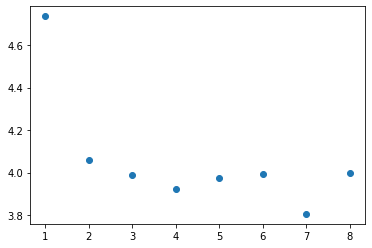

In [9]:
def final_run_regression(train, test, features_to_use, model=None, eval_metric=mean_squared_error,
  verbose = 0):

  if model is None: # try linear regression
    model = linear_model.LinearRegression(fit_intercept = True)

  X, X_test = train[features_to_use].values, test[features_to_use].values
  y, y_test = train[TARGET].values, test[TARGET].values
  y_ref = np.array([np.mean(y)] * len(y_test)) # use mean of y and predict on y_test
  
  model.fit(X, y)

  mse_in = eval_metric(y, model.predict(X))   
  mse_out = eval_metric(y_test, model.predict(X_test))  
  mse_ref = eval_metric(y_test, y_ref)

  if mse_ref == 0: # just to avoid divide by zero error
    mse_ref = 1.0e-6
  pct_improvement = 100*(mse_ref - mse_out)/mse_ref

  if verbose != 0:
    print(f"mse_in = {mse_in:0.3f}")
    print(f"mse_out = {mse_out:0.3f}, mse from average y prediction = {mse_ref:0.3f}")
    print(f"That is improvement of {pct_improvement:0.2f}%")
  return mse_in, mse_out, mse_ref

import time

begin = time.time()

features_to_use = get_best_features(train, TARGET, NUM_FOLDS, NUM_CV_TRIALS)
print(f"Using feartures {features_to_use}.")
model = linear_model.LinearRegression(fit_intercept = True)
mse_in, mse_out, mse_ref = final_run_regression(train, test, features_to_use,
  model, mean_squared_error, verbose = 1)

end = time.time()
print(f"Took {end-begin:0.4f} sec.")